<a href="https://colab.research.google.com/github/chengyang122/Metter.js-and-MediaPipe-Interactive-game/blob/main/Detectron2BarcodeX101FPNInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyYAML-5.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.6.3 requires PyYAML>=5.4, but you have pyyaml 5.1 which is incompatible.
torch:  1.11 ; cuda:  cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vuuabj2_
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vuuabj2_


In [3]:
import numpy as np
import pandas as pd
import cv2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from tqdm import tqdm
# import some common libraries
import numpy as np
import os, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/barcode/checkpoint/model_9991.pth'  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE='cpu'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 # set the testing threshold for this model
#cfg.DATASETS.TEST = ("boardetect_test", )
predictor = DefaultPredictor(cfg)
print('done')

In [5]:
def collect_predicted(result):
  Object, Mask = result
  useful_index = []
  for i in range(len(Object)):
    score = Object[i]
    if score > 0.6:
      useful_index.append(i)
  rects = []
  predicted_box = []
  predicted_contour = []
  for index in useful_index:
    mg = Mask[index].cpu().numpy().astype(np.uint8)
    contours, hierarchy = cv2.findContours(mg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rect = cv2.minAreaRect(cnt)
    rects.append(rect)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    predicted_box.append(box)
    predicted_contour.append(cnt)
  return predicted_box, predicted_contour, rects

In [6]:
im = cv2.imread('/content/drive/MyDrive/barcode/capture_2018_08_08_05_30_52.png')
outputs = predictor(im)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
result = (outputs["instances"].scores, outputs["instances"].pred_masks)
predicted_box, predicted_contour,rects = collect_predicted(result)

In [8]:
predicted_box

[array([[163, 725],
        [163, 519],
        [216, 519],
        [216, 725]]), array([[726, 712],
        [670, 709],
        [679, 501],
        [735, 503]]), array([[769, 347],
        [580, 247],
        [605, 201],
        [793, 300]]), array([[787, 244],
        [600, 142],
        [625,  97],
        [811, 198]]), array([[589, 762],
        [534, 760],
        [542, 550],
        [597, 552]]), array([[467, 699],
        [414, 698],
        [419, 489],
        [471, 490]]), array([[341, 630],
        [286, 628],
        [291, 420],
        [346, 422]]), array([[876, 786],
        [822, 784],
        [829, 577],
        [883, 579]])]

In [9]:
def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical, and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)
    if img_crop.shape[0]>img_crop.shape[1]:
      img_crop = cv2.rotate(img_crop, cv2.cv2.ROTATE_90_CLOCKWISE)
    return img_crop, img_rot

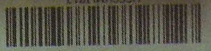

In [11]:
img_crop, img_rot = crop_rect(im, rects[3])
cv2_imshow(img_crop)

In [43]:
pip install pyzbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
pip install zbar


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for zbar
  Running setup.py clean for zbar
Failed to build zbar
    Running setup.py install for zbar ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ze7_e5c4/zbar_671a18b6cbda4abe9b3a7bd6f9089973/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ze7_e5c4/zbar_671a18b6cbda4abe9b3a7bd6f9089973/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-xh8_3699/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/zbar Check the logs for full command outpu

In [48]:
!sudo apt-get install libzbar0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libv4l-0 libv4lconvert0
The following NEW packages will be installed:
  libv4l-0 libv4lconvert0 libzbar0
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 193 kB of archives.
After this operation, 760 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libv4lconvert0 amd64 1.14.2-1 [76.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libv4l-0 amd64 1.14.2-1 [41.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libzbar0 amd64 0.10+doc-10.1build2 [75.7 kB]
Fetched 193 kB in 0s (800 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog

In [21]:
import pyzbar.pyzbar as pyzbar
import numpy as np
import cv2

In [22]:
(h, w) = img_crop.shape[:2]
(cX, cY) = (w // 2, h // 2)

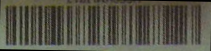

In [23]:
M = cv2.getRotationMatrix2D((cX, cY), -1, 1.0)
rotated = cv2.warpAffine(img_crop, M, (w, h))
cv2_imshow(rotated)

In [26]:
rotated.shape

(51, 211, 3)

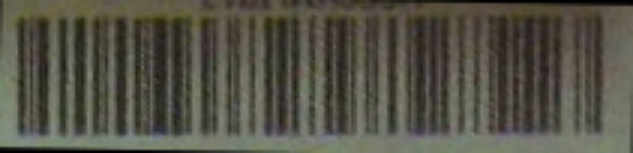

In [28]:
resized_image = cv2.resize(rotated, (rotated.shape[1]*3, rotated.shape[0]*3)) 
cv2_imshow(resized_image)

In [29]:
pyzbar.decode(resized_image)

[]

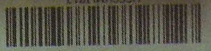

In [63]:
cv2_imshow(img_crop)

In [78]:
pip install kraken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.4 MB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 38.0 MB/s 
     |████████████████████████████████| 584 kB 38.0 MB/s 
     |████████████████████████████████| 232 kB 45.8 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
     |████████████████████████████████| 409 kB 61.2 MB/s 
     |████████████████████████████████| 140 kB 40.3 MB/s 
     |████████████████████████████████| 1.1 MB 51.8 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 49.5 MB/s 
     |████████████████████████████████| 271 kB 59.0 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1


In [19]:
from kraken import binarization
from PIL import Image
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol

image_path = "image.jpg"
# binarization using kraken
im = Image.fromarray(img_crop)
bw_im = binarization.nlbin(im)
# zbar
decode(bw_im, symbols=[ZBarSymbol.CODE128])

[]

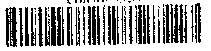

In [31]:
bw_im